In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylcp.integration_tools import parallelIntegrator

In [2]:
from inspect import signature
from scipy.integrate._ivp.bdf import BDF
from scipy.integrate._ivp.radau import Radau
from scipy.integrate._ivp.rk import RK23, RK45
from scipy.integrate._ivp.lsoda import LSODA
from scipy.optimize import OptimizeResult
from scipy.integrate._ivp.common import EPS, OdeSolution
from scipy.integrate._ivp.base import OdeSolver
from scipy.integrate._ivp.ivp import (prepare_events, solve_event_equation,
                                      handle_events, find_active_events)

METHODS = {'RK23': RK23,
           'RK45': RK45,
           'Radau': Radau,
           'BDF': BDF,
           'LSODA': LSODA}


MESSAGES = {0: "The solver successfully reached the end of the integration interval.",
            1: "A termination event occurred."}

class parallelIntegrator(object):
    """
    parallelIntegrator: a class to integrate a function as it is being called

    Parameters:
    ----------
    func : callable
        The function that is to be integrated.  It can have the form func(t) or 
        func(t,y).
        
    y0 : float or array, optional
        The initial value of y.  Default value is 0.
        
    method : string, optional
        Integration method to use:
            * 'RK45' (default): Explicit Runge-Kutta method of order 5(4) [1]_.
              The error is controlled assuming accuracy of the fourth-order
              method, but steps are taken using the fifth-order accurate
              formula (local extrapolation is done). A quartic interpolation
              polynomial is used for the dense output [2]_. Can be applied in
              the complex domain.
            * 'RK23': Explicit Runge-Kutta method of order 3(2) [3]_. The error
              is controlled assuming accuracy of the second-order method, but
              steps are taken using the third-order accurate formula (local
              extrapolation is done). A cubic Hermite polynomial is used for the
              dense output. Can be applied in the complex domain.
            * 'DOP853': Explicit Runge-Kutta method of order 8 [13]_.
              Python implementation of the "DOP853" algorithm originally
              written in Fortran [14]_. A 7-th order interpolation polynomial
              accurate to 7-th order is used for the dense output.
              Can be applied in the complex domain.
            * 'Radau': Implicit Runge-Kutta method of the Radau IIA family of
              order 5 [4]_. The error is controlled with a third-order accurate
              embedded formula. A cubic polynomial which satisfies the
              collocation conditions is used for the dense output.
            * 'BDF': Implicit multi-step variable-order (1 to 5) method based
              on a backward differentiation formula for the derivative
              approximation [5]_. The implementation follows the one described
              in [6]_. A quasi-constant step scheme is used and accuracy is
              enhanced using the NDF modification. Can be applied in the
              complex domain.
            * 'LSODA': Adams/BDF method with automatic stiffness detection and
              switching [7]_, [8]_. This is a wrapper of the Fortran solver
              from ODEPACK.
    tmax : float, optional
        Maximum magnitude of the time.  By default, 1e9.
    kwargs :
        Options passed to a chosen OdeSolver.

    Attributes
    ----------
    t0 : initial time of the integrator
    tlast : last time evaluated
    direction : direction of the integrator
    tmax : maximium value of integrator
    """
    def __init__(self, func, y0=[0.], method='RK45', tmax=1e9, **kwargs):
        if '(t, y' in str(signature(func)):
            self.func = func
        elif '(t' in str(signature(func)):
            self.func = lambda t, y: func(t)
        else:
            raise ValueError('signature %s for func not recognized'%str(signature(func)))

        self.t0 = None
        self.tlast = None
        self.direction = +1
        self.tmax = tmax
        # Now we can actually create the integrator:
        if method == 'RK45':
            self.intobj = RK45
        elif method == 'RK23':
            self.intobj = RK23
        elif method == 'DOP853':
            self.intobj = DOP853
        elif method == 'Radau':
            self.intobj = Radau
        elif method == 'BDF':
            self.intobj = BDF
        elif method == 'LSODA':
            self.intobj = LSODA
        else:
            raise ValueError('Method %s not recognized'%self.method)

        self.y0 = y0
        self.extra_kwargs = kwargs

    def __call__(self, t):
        """
        __call: return value at time t:

        Parameters:
        -----------
        t : float or array_like
            time at which to evaluate function

        Returns:
        --------
        y : float or array_like
            value of the function at time t.
        """
        if isinstance(t, np.ndarray):
            self.__step(np.amin(t)) # start the intergrator
            self.__step(np.amax(t)) # step the integrator through to max value
            
            # Rebuild the solution:
            sol = OdeSolution(self.ts, self.interpolants)
            
            return sol(t) # return the full array
        else:
            self.__step(t) # step integrator
            
            if t==self.t0:
                return self.y0
            else:
                # Rebuild the solution:
                sol = OdeSolution(self.ts, self.interpolants)

                return sol(t)
        
    def __step(self, t):
        # Is this the first call, or did we return to the initial time?
        if self.t0 is None or t==self.t0:
            self.t0 = t
            self.tlast = None
            self.interpolants = []
            self.ts = [t]
            
            # Return the initial value:
            return self.y0
        
        # Second call, we will now establish a direction and create the solver:
        elif self.tlast == None:
            if t>self.t0:
                self.direction = +1
            elif t<self.t0:
                self.direction = -1

            self.integrator=self.intobj(self.func, self.t0, self.y0,
                                        self.direction*self.tmax, **self.extra_kwargs)
        
        # Did we go to a value smaller than our initial value, given the
        # direction?
        elif (t<self.t0 and self.direction==+1) or (t>self.t0 and self.direction==-1):
            # Reset the integrator.
            self.t0=None
            self.tlast=None
            # Cute way to reset the integrator to a new starting t:
            return self(t) 

        # If we made it here, we did not reset yet:
        self.tlast = t

        # Now integrator up to t:
        while self.integrator.t<t:
            self.integrator.step()
            sol = self.integrator.dense_output()
            self.interpolants.append(sol)
            self.ts.append(self.integrator.t)

In [3]:
# def func_to_integrate(t):
#     dydt = -0.01*t
    
#     return dydt

# integrator = parallelIntegrator(func_to_integrate)

def func_to_integrate(t, y):
    dydt = [y[1], -y[0]]
    
    return dydt

integrator = parallelIntegrator(func_to_integrate, y0=[1., 0.])

## Do it one at a time

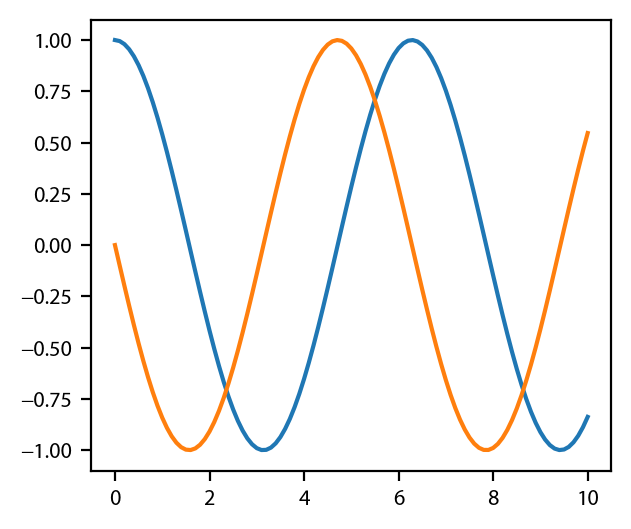

In [4]:
vals = []
ts = np.linspace(0, 10, 101)
for t in ts:
    vals.append(integrator(t))

vals = np.array(vals)

plt.plot(ts, vals)

## Mix arrays and floats:

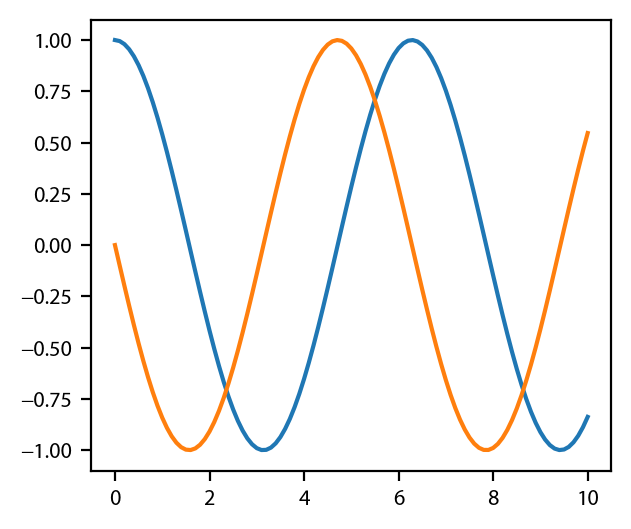

In [5]:
vals = (np.array([integrator(ts[0])]).T, integrator(ts[1:41]), np.array([integrator(ts[41])]).T, integrator(ts[42:]))
#vals = (np.array([integrator(ts[0])]), integrator(ts[1:41]), np.array([integrator(ts[41])]), integrator(ts[42:]))
vals = np.concatenate(vals, axis=1)

plt.plot(ts, vals.T)

## Reset the integator:

In [6]:
integrator(-np.pi/2)

[1.0, 0.0]

## Mix arrays and floats:

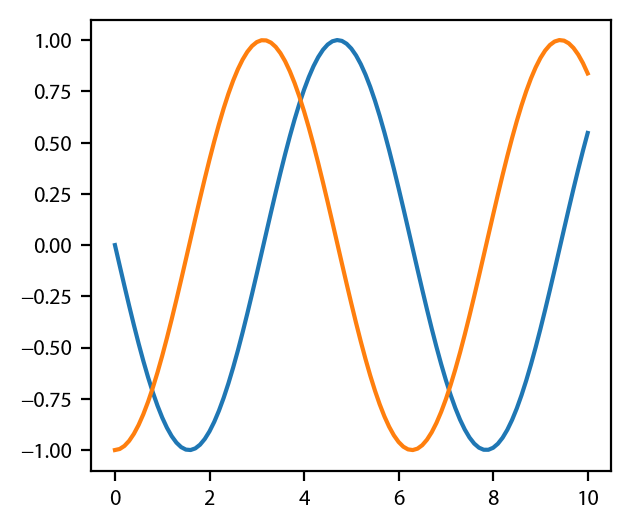

In [7]:
vals = (np.array([integrator(ts[0])]).T, integrator(ts[1:41]), np.array([integrator(ts[41])]).T, integrator(ts[42:]))
#vals = (np.array([integrator(ts[0])]), integrator(ts[1:41]), np.array([integrator(ts[41])]), integrator(ts[42:]))
vals = np.concatenate(vals, axis=1)

plt.plot(ts, vals.T)